# Quora Question Pairs
# Part 1. Baseline

[Kaggle competition](https://www.kaggle.com/c/quora-question-pairs)   
Anthony Kulesh  
Spring 2017

![Caption for the picture.](http://resource.mymagic.my/wp-content/uploads/2015/12/quora-e1451290677883.png)

## Description
Where else but Quora can a physicist help a chef with a math problem and get cooking tips in return? Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

## Evaluation
Submissions are evaluated on the log loss between the predicted values and the ground truth.  

$$-log P(y_{true}|~y_{pred}) = -(y_{true} * log(y_{pred}) + (1-y_{true}) * log(1-y_{pred}))$$

## Solutions
1. Abhishek Thakur. [Is That a Duplicate Quora Question?](https://www.linkedin.com/pulse/duplicate-quora-question-abhishek-thakur)  
2. @the1owl. [Matching ¿Que? for Quora - End to End 0.33719 PB](https://www.kaggle.com/the1owl/quora-question-pairs/matching-que-for-quora-end-to-end-0-33719-pb)  
3. @qianqian. [fm benchmark with tfidf around 29](https://github.com/qqgeogor/kaggle_quora_benchmark)

---
## Loading data
Required libraries

In [598]:
import time
import warnings
warnings.filterwarnings('ignore')

import pickle
import pandas as pd
import numpy as np
import difflib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

from fuzzywuzzy import fuzz
#import ml_insights as mli
import scipy.spatial as sp
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

Data

In [244]:
path_to_data = '/home/data/share/quora/'

train_data = pd.read_csv(path_to_data + 'train.csv')
test_data = pd.read_csv(path_to_data + 'test.csv')

In [245]:
print("Train size: %d" % train_data.shape[0])
print("Test size: %d" % test_data.shape[0])

Train size: 404290
Test size: 2345796


Sample submission

In [246]:
sample = pd.read_csv(path_to_data + 'sample_submission.csv')
sample.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


Features

In [453]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()

## Pickling data

In [248]:
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## Data exploration

In [249]:
print("Columns: %s" % list(train_data.columns))

Columns: ['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']


Brief info about columns

In [250]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [251]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


Missing values

In [252]:
train_data[train_data.question2.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [253]:
test_data[test_data.question2.isnull()]

,test_id,question1,question2
379205,379205,How I can learn android app development?,NaN
817520,817520,How real can learn android app development?,NaN
943911,943911,How app development?,NaN
1270024,1270024,How I can learn app development?,NaN


Replace NaN on string "empty"

In [254]:
train_data.fillna(value='empty', inplace=True)
test_data.fillna(value='empty', inplace=True)

Target

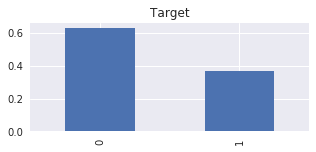

In [456]:
plt.figure(figsize=(5,2))
Y_train = train_data['is_duplicate']

plt.title("Target")
(Y_train.value_counts() / len(train_data)).plot(kind='bar');

## Feature extraction

In [256]:
questions_train = pd.concat((train_data.question1, train_data.question2))
questions_test = pd.concat((test_data.question1, test_data.question2))
all_questions = pd.concat((questions_train, questions_test))

In [257]:
print('%d/%d unique questions in Train' % (questions_train.nunique(), len(questions_train)))
print('%d/%d unique questions in Test' % (questions_test.nunique(), len(questions_test)))
print('%d/%d unique questions in all data' % (all_questions.nunique(), len(all_questions)))

537362/808580 unique questions in Train
4363832/4691592 unique questions in Test
4789032/5500172 unique questions in all data


#### Count words in questions

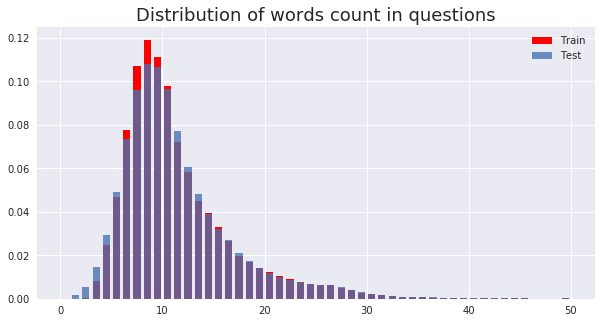

Max count of words in Train questions: 237
Max count of words in Test questions: 238

Min count of words in Train questions: 1
Min count of words in Test questions: 1

Mean count of words in Train questions: 11
Mean count of words in Test questions: 11

Median count of words in Train questions: 10
Median count of words in Test questions: 10



In [457]:
count_train = questions_train.apply(lambda x: len(x.split()))
count_test = questions_test.apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.hist(count_train, range=[0,50], bins=50, rwidth=.7, normed=True, color='red', label='Train')
plt.hist(count_test, range=[0,50], bins=50, rwidth=.7, normed=True, alpha=0.8, label='Test')
plt.title("Distribution of words count in questions", fontsize=18)
plt.legend()
plt.show()

print("Max count of words in Train questions: %d" % (count_train.max()))
print("Max count of words in Test questions: %d\n" % (count_test.max()))
print("Min count of words in Train questions: %d" % (count_train.min()))
print("Min count of words in Test questions: %d\n" % (count_test.min()))
print("Mean count of words in Train questions: %d" % (count_train.mean()))
print("Mean count of words in Test questions: %d\n" % (count_test.mean()))
print("Median count of words in Train questions: %d" % (count_train.median()))
print("Median count of words in Test questions: %d\n" % (count_test.median()))

In [458]:
n_train = len(train_data)
n_test = len(test_data)

In [459]:
X_train['word_count_q1'] = count_train[:n_train]
X_train['word_count_q2'] = count_train[n_train:]
X_test['word_count_q1'] = count_test[:n_test]
X_test['word_count_q2'] = count_test[n_test:]

#### Abs(Word_Count(q1) - Word_Count(q2))

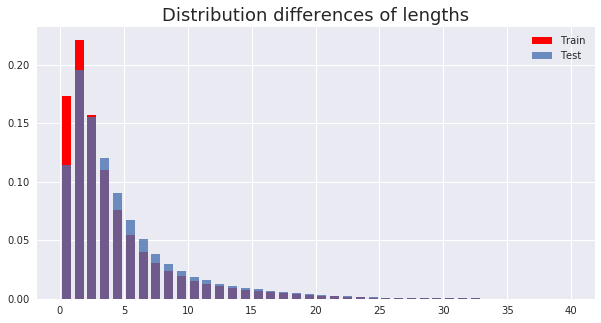

In [460]:
diff_count_train = np.abs(count_train[:n_train] - count_train[n_train:])
diff_count_test = np.abs(count_test[:n_test] - count_test[n_test:])

plt.figure(figsize=(10,5))
plt.hist(diff_count_train, range=[0,40], bins=40, rwidth=.7, normed=True, color='red', label='Train')
plt.hist(diff_count_test, range=[0,40], bins=40, rwidth=.7, normed=True, alpha=0.8, label='Test')
plt.title("Distribution differences of lengths", fontsize=18)
plt.legend()
plt.show()

In [461]:
X_train['diff_word_count'] = diff_count_train
X_test['diff_word_count'] = diff_count_test

X_train.head()

,word_count_q1,word_count_q2,diff_word_count
0,14,12,2
1,8,13,5
2,14,10,4
3,11,9,2
4,13,7,6


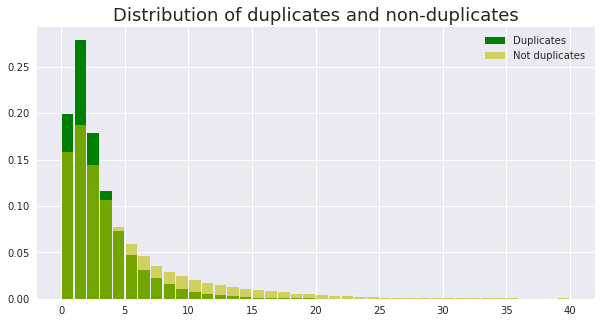

In [462]:
is_dup = Y_train == 1

plt.figure(figsize=(10,5))
plt.hist(diff_count_train[is_dup], range=[0,40], bins=40, rwidth=.9, normed=True, color='g', label='Duplicates')
plt.hist(diff_count_train[~is_dup], range=[0,40], bins=40, rwidth=.9, normed=True, color='y', alpha=0.6, label='Not duplicates')
plt.title("Distribution of duplicates and non-duplicates", fontsize=18)
plt.legend()
plt.show()

#### Length questions without stopwords

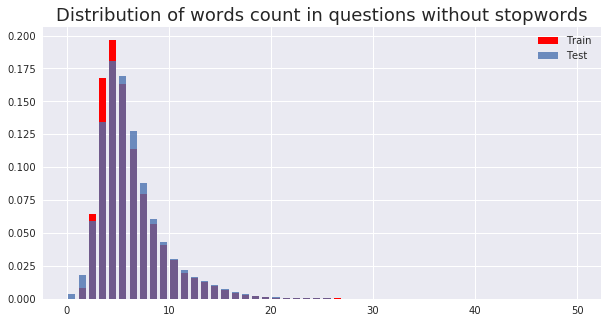

In [463]:
count_train = questions_train.apply(lambda x: len([w for w in x.split() if w.lower() not in stops]))
count_test = questions_test.apply(lambda x: len([w for w in x.split() if w.lower() not in stops]))

plt.figure(figsize=(10,5))
plt.hist(count_train, range=[0,50], bins=50, rwidth=.7, normed=True, color='red', label='Train')
plt.hist(count_test, range=[0,50], bins=50, rwidth=.7, normed=True, alpha=0.8, label='Test')
plt.title("Distribution of words count in questions without stopwords", fontsize=18)
plt.legend()
plt.show()

In [464]:
X_train['nonstop_count_q1'] = count_train[:n_train]
X_train['nonstop_count_q2'] = count_train[n_train:]
X_test['nonstop_count_q1'] = count_test[:n_test]
X_test['nonstop_count_q2'] = count_test[n_test:]

#### Abs(Word_Count(q1) - Word_Count(q2)) without stopwords

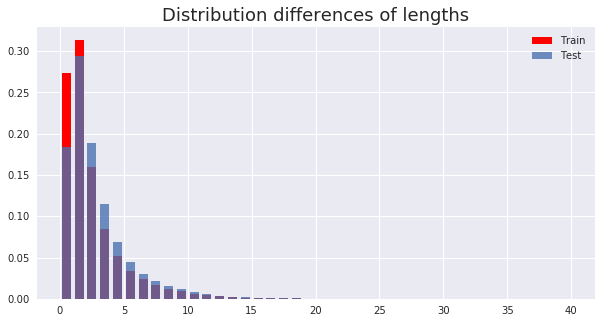

In [465]:
diff_count_train = np.abs(count_train[:n_train] - count_train[n_train:])
diff_count_test = np.abs(count_test[:n_test] - count_test[n_test:])

plt.figure(figsize=(10,5))
plt.hist(diff_count_train, range=[0,40], bins=40, rwidth=.7, normed=True, color='red', label='Train')
plt.hist(diff_count_test, range=[0,40], bins=40, rwidth=.7, normed=True, alpha=0.8, label='Test')
plt.title("Distribution differences of lengths", fontsize=18)
plt.legend()
plt.show()

In [466]:
X_train['diff_nonstopword_count'] = diff_count_train
X_test['diff_nonstopword_count'] = diff_count_test

X_train.head()

,word_count_q1,word_count_q2,diff_word_count,nonstop_count_q1,nonstop_count_q2,diff_nonstopword_count
0,14,12,2,7,6,1
1,8,13,5,4,9,5
2,14,10,4,6,5,1
3,11,9,2,4,5,1
4,13,7,6,10,5,5


#### Different words

In [575]:
def diff_words(q1, q2):
    set_1 = set(q1.lower().split())
    set_2 = set(q2.lower().split())
    return len(set_1.symmetric_difference(set_2))

In [576]:
%%time

X_train['symmetric_diff'] = [diff_words(qtrain[0].loc[i], qtrain[0].loc[n_train + i]) for i in range(n_train)]
X_test['symmetric_diff'] = [diff_words(qtest[0].loc[i], qtest[0].loc[n_test + i]) for i in range(n_test)]

CPU times: user 2min 54s, sys: 4.22 ms, total: 2min 54s
Wall time: 2min 54s


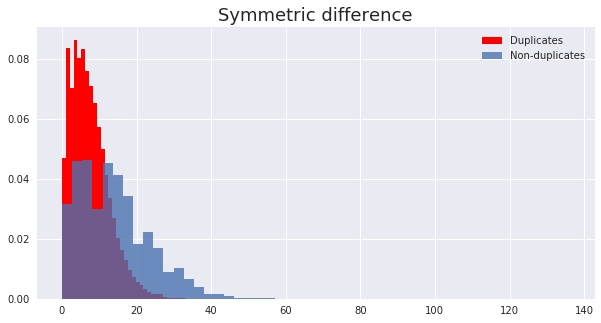

In [584]:
mask = np.array(Y_train == 1)

plt.figure(figsize=(10,5))
plt.hist(X_train['symmetric_diff'][mask], bins=50, normed=True, color='red', label='Duplicates')
plt.hist(X_train['symmetric_diff'][~mask], bins=50, normed=True, alpha=0.8, label='Non-duplicates')
plt.title("Symmetric difference", fontsize=18)
plt.legend()
plt.show()

TO DO

About distributions

#### Count chars in questions

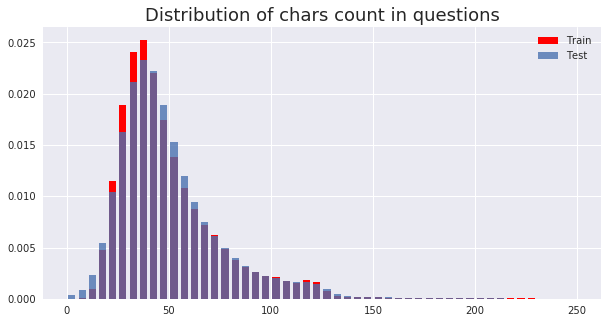

Max count of chars in Train questions: 942
Max count of chars in Test questions: 948

Min count of chars in Train questions: 1
Min count of chars in Test questions: 1

Mean count of chars in Train questions: 49
Mean count of chars in Test questions: 50

Median count of chars in Train questions: 43
Median count of chars in Test questions: 44



In [467]:
count_char_train = questions_train.apply(lambda x: len(''.join(str(x).replace(' ', ''))))
count_char_test = questions_test.apply(lambda x: len(''.join(str(x).replace(' ', ''))))

plt.figure(figsize=(10,5))
plt.hist(count_char_train, range=[0,250], bins=50, rwidth=.7, normed=True, color='red', label='Train')
plt.hist(count_char_test, range=[0,250], bins=50, rwidth=.7, normed=True, alpha=0.8, label='Test')
plt.title("Distribution of chars count in questions", fontsize=18)
plt.legend()
plt.show()

print("Max count of chars in Train questions: %d" % (count_char_train.max()))
print("Max count of chars in Test questions: %d\n" % (count_char_test.max()))
print("Min count of chars in Train questions: %d" % (count_char_train.min()))
print("Min count of chars in Test questions: %d\n" % (count_char_test.min()))
print("Mean count of chars in Train questions: %d" % (count_char_train.mean()))
print("Mean count of chars in Test questions: %d\n" % (count_char_test.mean()))
print("Median count of chars in Train questions: %d" % (count_char_train.median()))
print("Median count of chars in Test questions: %d\n" % (count_char_test.median()))

In [468]:
X_train['char_count_q1'] = count_char_train[:n_train]
X_train['char_count_q2'] = count_char_train[n_train:]
X_test['char_count_q1'] = count_char_test[:n_test]
X_test['char_count_q2'] = count_char_test[n_test:]

#### Special chars

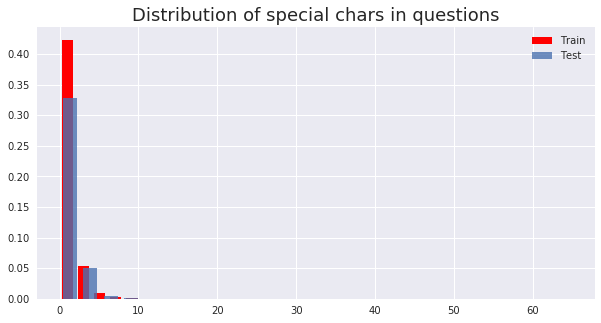

In [469]:
spec_char_train = questions_train.apply(lambda x: len([w for w in x.split() if not w.isalpha()]))
spec_char_test = questions_test.apply(lambda x: len([w for w in x.split() if not w.isalpha()]))

plt.figure(figsize=(10,5))
plt.hist(spec_char_train, bins=25, rwidth=.7, normed=True, color='red', label='Train')
plt.hist(spec_char_test, bins=25, rwidth=.7, normed=True, alpha=0.8, label='Test')
plt.title("Distribution of special chars in questions", fontsize=18)
plt.legend()
plt.show()

In [470]:
X_train['spec_char_q1'] = spec_char_train[:n_train]
X_train['spec_char_q2'] = spec_char_train[n_train:]
X_test['spec_char_q1'] = spec_char_test[:n_test]
X_test['spec_char_q2'] = spec_char_test[n_test:]

#### Match ratio

In [471]:
def diff_ratio(q1, q2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(q1).lower(), str(q2).lower())
    return seq.ratio()

In [472]:
%%time

X_train['match_ratio'] = train_data.apply(lambda r: diff_ratio(r.question1, r.question2), axis=1) 
X_test['match_ratio'] = test_data.apply(lambda r: diff_ratio(r.question1, r.question2), axis=1) 

CPU times: user 10min 53s, sys: 55.8 ms, total: 10min 54s
Wall time: 10min 54s


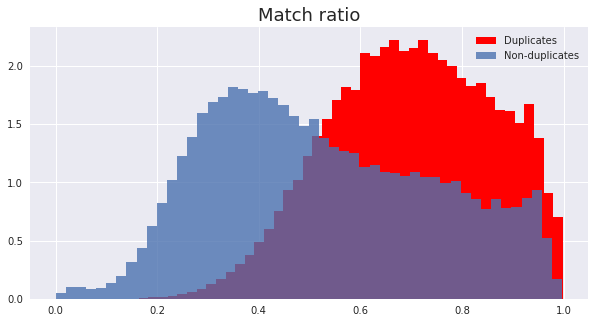

In [473]:
mask = np.array(Y_train == 1)

plt.figure(figsize=(10,5))
plt.hist(X_train['match_ratio'][mask], bins=50, normed=True, color='red', label='Duplicates')
plt.hist(X_train['match_ratio'][~mask], bins=50, normed=True, alpha=0.8, label='Non-duplicates')
plt.title("Match ratio", fontsize=18)
plt.legend()
plt.show()

### Fuzzy features
[FuzzyWuzzy](https://github.com/seatgeek/fuzzywuzzy): Fuzzy string matching like a boss. It uses Levenshtein Distance to calculate the differences between sequences in a simple-to-use package.

In [586]:
%%time

X_train['fuzz_qratio'] = train_data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
X_train['fuzz_WRatio'] = train_data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
X_train['fuzz_partial_ratio'] = train_data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
X_train['fuzz_partial_token_set_ratio'] = train_data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
X_train['fuzz_partial_token_sort_ratio'] = train_data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
X_train['fuzz_token_set_ratio'] = train_data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
X_train['fuzz_token_sort_ratio'] = train_data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

X_test['fuzz_qratio'] = test_data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
X_test['fuzz_WRatio'] = test_data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
X_test['fuzz_partial_ratio'] = test_data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
X_test['fuzz_partial_token_set_ratio'] = test_data.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
X_test['fuzz_partial_token_sort_ratio'] = test_data.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
X_test['fuzz_token_set_ratio'] = test_data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
X_test['fuzz_token_sort_ratio'] = test_data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

CPU times: user 32min 24s, sys: 1.01 s, total: 32min 25s
Wall time: 32min 25s


### Text processing

In [333]:
def lemmatization_word(word):
    pos = ['a','v','n','r']
    lemmatizer = WordNetLemmatizer()
    for p in pos:
        temp = lemmatizer.lemmatize(word, p)
        if temp != word:
            return temp
    return word  

def cleaning_texts(questions, punc=False, lemma=False):
    tokenizer = nltk.word_tokenize
    q_tokens = [tokenizer(question) for question in questions]
    
    if punc:
        q_tokens = [[word.lower() for word in tokens] \
                    for tokens in q_tokens]
    else:
        q_tokens = [[word.lower() for word in tokens \
                    if word.isalnum()] for tokens in q_tokens]
    if lemma:
        q_tokens = [[lemmatization_word(word) for word in tokens] \
                  for tokens in q_tokens]
        
    string = [' '.join(text) for text in q_tokens]
    return string

In [334]:
cleaning_texts(questions_train[:10], punc=True)

['what is the step by step guide to invest in share market in india ?',
 'what is the story of kohinoor ( koh-i-noor ) diamond ?',
 'how can i increase the speed of my internet connection while using a vpn ?',
 'why am i mentally very lonely ? how can i solve it ?',
 'which one dissolve in water quikly sugar , salt , methane and carbon di oxide ?',
 'astrology : i am a capricorn sun cap moon and cap rising ... what does that say about me ?',
 'should i buy tiago ?',
 'how can i be a good geologist ?',
 'when do you use シ instead of し ?',
 'motorola ( company ) : can i hack my charter motorolla dcx3400 ?']

In [171]:
%%time

qtrain = pd.Series(cleaning_texts(questions_train, punc=True))
qtest = pd.Series(cleaning_texts(questions_test, punc=True))

############### Saving #########################
#
qtrain.to_csv('questions_train.csv', index=False)
qtest.to_csv('questions_test.csv', index=False)

CPU times: user 9min 41s, sys: 2.75 s, total: 9min 44s
Wall time: 9min 44s


In [380]:
%%time

qtrain_lem = pd.Series(cleaning_texts(questions_train, punc=True, lemma=True))
qtest_lem = pd.Series(cleaning_texts(questions_test, punc=True, lemma=True))

############### Saving #########################
#
qtrain_lem.to_csv('questions_train_lem.csv', index=False)
qtest_lem.to_csv('questions_test_lem.csv', index=False)

CPU times: user 21min 32s, sys: 3.35 s, total: 21min 35s
Wall time: 21min 35s


Loading

In [397]:
qtrain = pd.read_csv('questions_train.csv', header=None)
qtest = pd.read_csv('questions_test.csv', header=None).fillna('empty')
all_questions = pd.concat((qtrain, qtest))

qtrain_lem = pd.read_csv('questions_train_lem.csv', header=None)
qtest_lem = pd.read_csv('questions_test_lem.csv', header=None).fillna('empty')
all_questions_lem = pd.concat((qtrain_lem, qtest_lem))

### Jaccard similarity  
$$J(Q_1, Q_2) = \frac{|Q_1 \cap Q_2|}{|Q_1 \cup Q_2|}$$
[Link](https://en.wikipedia.org/wiki/Jaccard_index) to Wiki page

In [381]:
def jaccard_sim(q1, q2, stop=True):
    set_1 = set(q1.lower().split())
    set_2 = set(q2.lower().split())
    if stop:
        set_1 = set_1 - stops
        set_2 = set_2 - stops
    try:
        jaccard = len(set_1.intersection(set_2)) / len(set_1.union(set_2))
    except ZeroDivisionError:
        jaccard = 0
    return jaccard

In [474]:
%%time

X_train['jaccard'] = [jaccard_sim(qtrain[0].loc[i], qtrain[0].loc[n_train + i]) for i in range(n_train)]
X_train['jaccard_stop'] = [jaccard_sim(qtrain[0].loc[i], qtrain[0].loc[n_train + i], False) for i in range(n_train)]
X_train['jaccard_split'] = [jaccard_sim(train_data['question1'].loc[i], train_data['question2'].loc[i]) for i in range(n_train)]
X_train['jaccard_lem'] = [jaccard_sim(qtrain_lem[0].loc[i], qtrain_lem[0].loc[n_train + i]) for i in range(n_train)]

X_test['jaccard'] = [jaccard_sim(qtest[0].loc[i], qtest[0].loc[n_test + i]) for i in range(n_test)]
X_test['jaccard_stop'] = [jaccard_sim(qtest[0].loc[i], qtest[0].loc[n_test + i], False) for i in range(n_test)]
X_test['jaccard_split'] = [jaccard_sim(test_data['question1'].loc[i], test_data['question2'].loc[i]) for i in range(n_test)]
X_test['jaccard_lem'] = [jaccard_sim(qtest_lem[0].loc[i], qtest_lem[0].loc[n_test + i]) for i in range(n_test)]

CPU times: user 12min 8s, sys: 13.9 ms, total: 12min 8s
Wall time: 12min 8s


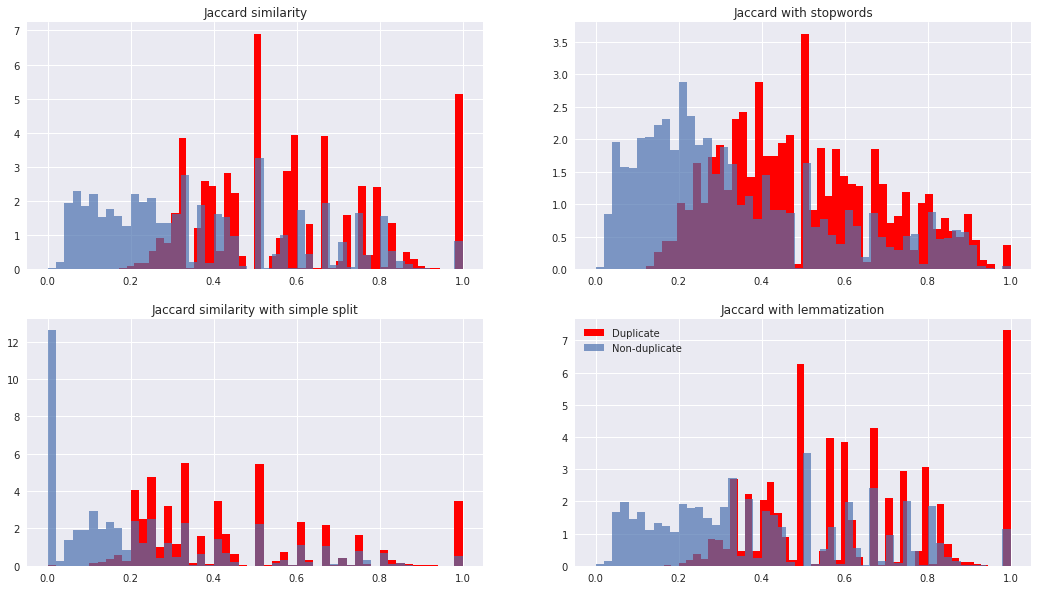

In [475]:
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.title("Jaccard similarity")
plt.hist(X_train['jaccard'][mask], bins=50, color='r', normed=True, label='Duplicate');
plt.hist(X_train['jaccard'][~mask], bins=50, alpha=0.7, normed=True, label='Non-duplicate');

plt.subplot(2,2,2)
plt.title("Jaccard with stopwords")
plt.hist(X_train['jaccard_stop'][mask], bins=50, color='r', normed=True, label='Duplicate');
plt.hist(X_train['jaccard_stop'][~mask], bins=50, alpha=0.7, normed=True, label='Non-duplicate');

plt.subplot(2,2,3)
plt.title("Jaccard similarity with simple split")
plt.hist(X_train['jaccard_split'][mask], bins=50, color='r', normed=True, label='Duplicate');
plt.hist(X_train['jaccard_split'][~mask], bins=50, alpha=0.7, normed=True, label='Non-duplicate');

plt.subplot(2,2,4)
plt.title("Jaccard with lemmatization")
plt.hist(X_train['jaccard_lem'][mask], bins=50, color='r', normed=True, label='Duplicate');
plt.hist(X_train['jaccard_lem'][~mask], bins=50, alpha=0.7, normed=True, label='Non-duplicate');

plt.legend()
plt.show()

### Overlap
$$O(Q_1, Q_2) = \frac{|Q_1 \cap Q_2|}{min(|Q_1|, |Q_2|)}$$

In [476]:
def overlap(q1, q2, stop=True):
    set_1 = set(q1.split())
    set_2 = set(q2.split())
    if stop:
        set_1 = set_1 - stops
        set_2 = set_2 - stops
    try:
        result = len(set_1.intersection(set_2)) / min(len(set_1), len(set_2))
    except ZeroDivisionError:
        result = 0
    return result

In [477]:
%%time

X_train['overlap'] = [overlap(qtrain[0].loc[i], qtrain[0].loc[n_train + i]) for i in range(n_train)]
X_train['overlap_stop'] = [overlap(qtrain[0].loc[i], qtrain[0].loc[n_train + i], False) for i in range(n_train)]
X_train['overlap_split'] = [overlap(train_data['question1'].loc[i], train_data['question2'].loc[i]) for i in range(n_train)]
X_train['overlap_lem'] = [overlap(qtrain_lem[0].loc[i], qtrain_lem[0].loc[n_train + i]) for i in range(n_train)]

X_test['overlap'] = [overlap(qtest[0].loc[i], qtest[0].loc[n_test + i]) for i in range(n_test)]
X_test['overlap_stop'] = [overlap(qtest[0].loc[i], qtest[0].loc[n_test + i], False) for i in range(n_test)]
X_test['overlap_split'] = [overlap(test_data['question1'].loc[i], test_data['question2'].loc[i]) for i in range(n_test)]
X_test['overlap_lem'] = [overlap(qtest_lem[0].loc[i], qtest_lem[0].loc[n_test + i]) for i in range(n_test)]

CPU times: user 11min 41s, sys: 22.7 ms, total: 11min 41s
Wall time: 11min 41s


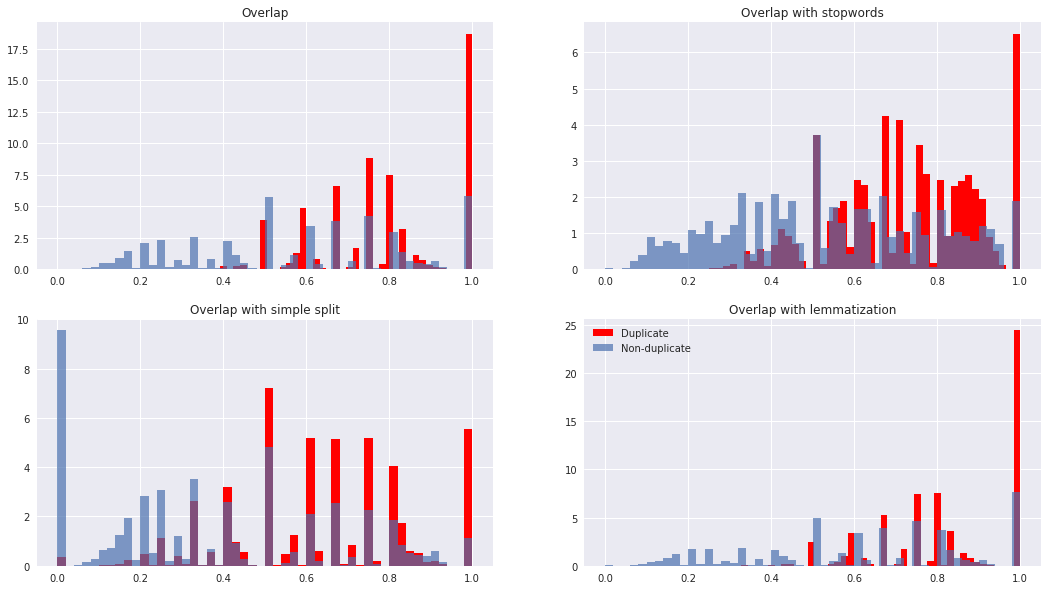

In [478]:
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.title("Overlap")
plt.hist(X_train['overlap'][mask], bins=50, color='r', normed=True, label='Duplicate');
plt.hist(X_train['overlap'][~mask], bins=50, alpha=0.7, normed=True, label='Non-duplicate');

plt.subplot(2,2,2)
plt.title("Overlap with stopwords")
plt.hist(X_train['overlap_stop'][mask], bins=50, color='r', normed=True, label='Duplicate');
plt.hist(X_train['overlap_stop'][~mask], bins=50, alpha=0.7, normed=True, label='Non-duplicate');

plt.subplot(2,2,3)
plt.title("Overlap with simple split")
plt.hist(X_train['overlap_split'][mask], bins=50, color='r', normed=True, label='Duplicate');
plt.hist(X_train['overlap_split'][~mask], bins=50, alpha=0.7, normed=True, label='Non-duplicate');

plt.subplot(2,2,4)
plt.title("Overlap with lemmatization")
plt.hist(X_train['overlap_lem'][mask], bins=50, color='r', normed=True, label='Duplicate');
plt.hist(X_train['overlap_lem'][~mask], bins=50, alpha=0.7, normed=True, label='Non-duplicate');

plt.legend()
plt.show()

## Bag-of-words
**Bag-of-unigrams**

In [251]:
%%time

vect = CountVectorizer(ngram_range=(1,1), min_df=2, tokenizer=nltk.word_tokenize, lowercase=False)
vect.fit(all_questions[0])

print("Vocabulary size: %d" % len(vect.vocabulary_))

Vocabulary size: 133241
CPU times: user 9min 54s, sys: 264 ms, total: 9min 55s
Wall time: 9min 55s


In [252]:
print(vect.get_feature_names()[-100:])

['莫斯科郊外的晚上。一个静悄悄的无风之夜。', '菁菁', '萌', '蔣介石', '蚂蚁上树means', '袁世凱', '要', '親しみやすい', '觉得', '譬如朝露，去日苦多', '贰', '费玲瓏', '资本', '资质文件', '走关系？', '身に付ける', '过去', '过来', '这一切', '逆天', '逆転の法則', '這是什麽', '逢十进一', '道德', '道德绑架', '遗世独立', '那108根风格迥异的桂子分别来自世界上数十不闶泉和地区，柤乡日长短不一，有的古朴，相梏，有的纤细，椿致，例如印度的州市子柱，埃及驻等。', '酒店', '野口', '长夜难明赤县天，百年魔怪舞翩跹', '開了', '阿', '隔壁老王', '韩帅', '頑張って', '骂人', '骚客', '高大上', '鴻日', '鹵水', '黄勁智', '鼠', '齐家', '가능해요', '가요', '교환이', '그런데', '근데', '누나', '니콜라스에게', '됐어요', '되다', '되셨으면', '런닝맨', '미안하다', '보고', '사진느낌', '산', '선팔하고', '슬마', '심하잖아', '싸가지', '안', '알아요', '알았어요', '오재호', '이정현', '이주일이', '정', '지', '충만해서', '쾌지나칭칭나네', '하지만', '한글', '황경지', '\uf02dc', '\uf03d', '\uf0b7name', '\uf0ba', '\uf0d8', '\uf0fc', '\uf105', 'ﬁnd', '\ufeff', '\ufeffthe', '（一等洋人二等官，三等少民四等汉）', '（頑張って）used', '（頑張れ）and', '，and', '，but', '，i', '，|', '？', '？and', 'ｦb､sｦbｧﾖｳtｷｻｸﾑ', '￦¥§¤㊙㊗', '￼', '￼what', '￼will', '￼would']


Transforming texts to sparse term-question-matrix 

In [253]:
%%time

q1_train = vect.transform(qtrain[0][:n_train])
q2_train = vect.transform(qtrain[0][n_train:])

q1_test = vect.transform(qtest[0][:n_test])
q2_test = vect.transform(qtest[0][n_test:])

CPU times: user 10min 23s, sys: 195 ms, total: 10min 24s
Wall time: 10min 29s


In [254]:
############ Saving ######################
#
#pickling_data('q1_train_unigram', q1_train)
#pickling_data('q2_train_unigram', q2_train)
#pickling_data('q1_test_unigram', q1_test)
#pickling_data('q2_test_unigram', q2_test)

In [611]:
############## Loading ###################
#
q1_train = load_data('q1_train_unigram')
q2_train = load_data('q2_train_unigram')
q1_test = load_data('q1_test_unigram')
q2_test = load_data('q2_test_unigram')

### TF-IDF transformation

In [83]:
%%time

vect = TfidfVectorizer(ngram_range=(1,1), min_df=2, tokenizer=nltk.word_tokenize, lowercase=False)
vect.fit(all_questions[0])

print("Vocabulary size: %d" % len(vect.vocabulary_))

############# Transforming ###################
q1_train = vect.transform(qtrain[0][:n_train])
q2_train = vect.transform(qtrain[0][n_train:])
q1_test = vect.transform(qtest[0][:n_test])
q2_test = vect.transform(qtest[0][n_test:])

Vocabulary size: 133241
CPU times: user 21min 21s, sys: 810 ms, total: 21min 22s
Wall time: 21min 23s


In [84]:
################ Saving ####################
#
#pickling_data('q1_train_tfidf_unigram', q1_train)
#pickling_data('q2_train_tfidf_unigram', q2_train)
#pickling_data('q1_test_tfidf_unigram', q1_test)
#pickling_data('q2_test_tfidf_unigram', q2_test)

In [612]:
############## Loading ###################
#
q1_train_tf = load_data('q1_train_tfidf_unigram')
q2_train_tf = load_data('q2_train_tfidf_unigram')
q1_test_tf = load_data('q1_test_tfidf_unigram')
q2_test_tf = load_data('q2_test_tfidf_unigram')

TF-IDF features

In [713]:
%%time

X_train['tfidf_sum1'] = q1_train_tf.sum(axis = 1)
X_train['tfidf_sum2'] = q2_train_tf.sum(axis = 1)
X_train['tfidf_len1'] = q1_train_tf.sign().sum(axis = 1)
X_train['tfidf_len2'] = q2_train_tf.sign().sum(axis = 1)
X_train['tfidf_mean1'] = X_train['tfidf_sum1'] / X_train['tfidf_len1']
X_train['tfidf_mean2'] = X_train['tfidf_sum2'] / X_train['tfidf_len2']

X_test['tfidf_sum1'] = q1_test_tf.sum(axis = 1)
X_test['tfidf_sum2'] = q2_test_tf.sum(axis = 1)
X_test['tfidf_len1'] = q1_test_tf.sign().sum(axis = 1)
X_test['tfidf_len2'] = q2_test_tf.sign().sum(axis = 1)
X_test['tfidf_mean1'] = X_test['tfidf_sum1'] / X_test['tfidf_len1']
X_test['tfidf_mean2'] = X_test['tfidf_sum2'] / X_test['tfidf_len2']

CPU times: user 494 ms, sys: 31.7 ms, total: 526 ms
Wall time: 481 ms


### Cosine similarity
1. [Is cosine similarity effective?](https://www.quora.com/Is-cosine-similarity-effective)  
2. [Wiki page](https://en.wikipedia.org/wiki/Cosine_similarity)

In [614]:
def cos_sim(q1_mtx, q2_mtx, n=n_train):
    
    labels = np.append(np.arange(0, n, 30000), n)
    sim = np.array([])

    for i in range(len(labels)-1):
        start = labels[i]
        end = labels[i+1]
        chunk = cosine_similarity(q1_mtx[start:end], q2_mtx[start:end], dense_output=False)
        sim = np.append(sim, chunk.diagonal()) 
    return sim

In [617]:
%%time

X_train['unigram_cos'] = cos_sim(q1_train, q2_train, n=n_train)
X_test['unigram_cos'] = cos_sim(q1_test, q2_test, n=n_test)

X_train['unigram_tfidf_cos'] = cos_sim(q1_train_tf, q2_train_tf, n=n_train)
X_test['unigram_tfidf_cos'] = cos_sim(q1_test_tf, q2_test_tf, n=n_test)

CPU times: user 30min 20s, sys: 1min 59s, total: 32min 20s
Wall time: 32min 21s


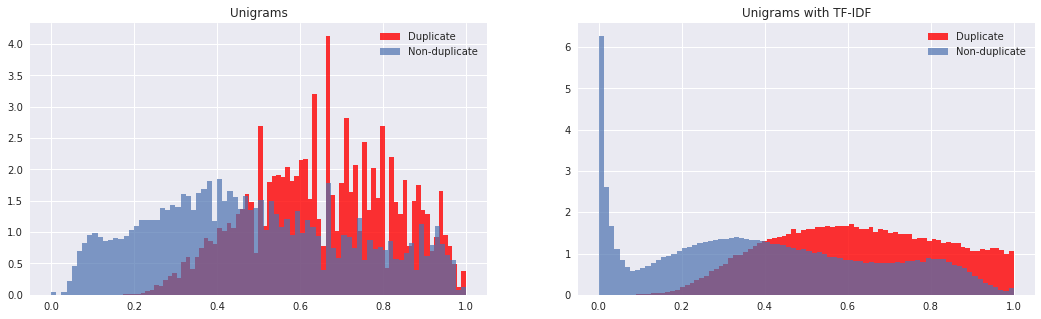

In [623]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Unigrams")
plt.hist(X_train['unigram_cos'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['unigram_cos'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Unigrams with TF-IDF")
plt.hist(X_train['unigram_tfidf_cos'][mask], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['unigram_tfidf_cos'][~mask], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()
plt.show()

**False Duplicates**

In [625]:
false_pos = train_data[(X_train['unigram_cos'] > 0.99) & ~mask][['question1', 'question2', 'is_duplicate']]
print(false_pos.shape)
false_pos.head(10)

(355, 3)


,question1,question2,is_duplicate
240,What is the temperament of a Bullmastiff/Husky...,What is the temperament of a Corgi-Husky mix?,0
2850,What does tw4t mean?,What does 분위기 mean?,0
3148,How do I overcome my inferiority complex ?,How do I overcome my inferiority complex?,0
5182,Is God capable of disproving the existence of ...,Is science capable of disproving the existence...,0
5920,What are some countable words that are likely ...,What are some uncountable words that are likel...,0
6238,Are cats afraid of tigers?,Are tigers afraid of cats?,0
6279,Why is Google Chrome not working but Internet ...,Why is Internet Explorer not working but Googl...,0
6591,How has Disney's culture changed since the Pix...,How has Pixar's culture changed since the Disn...,0
6840,What are some things you can do in the USA but...,What are some things you can do in France but ...,0
8262,What happened to Tmartn?,What happened to Papercuts777?,0


In [626]:
train_data[(X_train['unigram_tfidf_cos'] == 1) & ~mask][['question1', 'question2', 'is_duplicate']].head(10)

,question1,question2,is_duplicate
2850,What does tw4t mean?,What does 분위기 mean?,0
3148,How do I overcome my inferiority complex ?,How do I overcome my inferiority complex?,0
5920,What are some countable words that are likely ...,What are some uncountable words that are likel...,0
6591,How has Disney's culture changed since the Pix...,How has Pixar's culture changed since the Disn...,0
6840,What are some things you can do in the USA but...,What are some things you can do in France but ...,0
8262,What happened to Tmartn?,What happened to Papercuts777?,0
8285,What is the most common mental illness?,What is the most common self-diagnosed mental ...,0
9303,What is cancer?,What is mesothelia cancer?,0
12606,What is coal?,What is lignite coal?,0
17475,What is OpenDomainMarket.com worth?,What is DroneAppz.com worth?,0


## Bag-of-chars

In [150]:
%%time

vect = TfidfVectorizer(ngram_range=(1,4), lowercase=False, min_df=2, max_df=0.1, analyzer='char')
vect.fit(qtrain[0])

print("Vocabulary size: %d" % len(vect.vocabulary_))

############# Transforming ###################
q1_train = vect.transform(qtrain[0][:n_train])
q2_train = vect.transform(qtrain[0][n_train:])
q1_test = vect.transform(qtest[0][:n_test])
q2_test = vect.transform(qtest[0][n_test:])

Vocabulary size: 161557
CPU times: user 15min, sys: 2.5 s, total: 15min 2s
Wall time: 15min 2s


In [151]:
################ Saving ####################
#
#pickling_data('q1_train_char', q1_train)
#pickling_data('q2_train_char', q2_train)
#pickling_data('q1_test_char', q1_test)
#pickling_data('q2_test_char', q2_test)

In [671]:
############## Loading ###################
#
q1_train_char = load_data('q1_train_char')
q2_train_char = load_data('q2_train_char')
q1_test_char = load_data('q1_test_char')
q2_test_char = load_data('q2_test_char')

In [673]:
%%time

X_train['char_tfidf_cos'] = cos_sim(q1_train_char, q2_train_char, n=n_train)
X_test['char_tfidf_cos'] = cos_sim(q1_test_char, q2_test_char, n=n_test)

CPU times: user 25min 34s, sys: 25.4 s, total: 25min 59s
Wall time: 26min


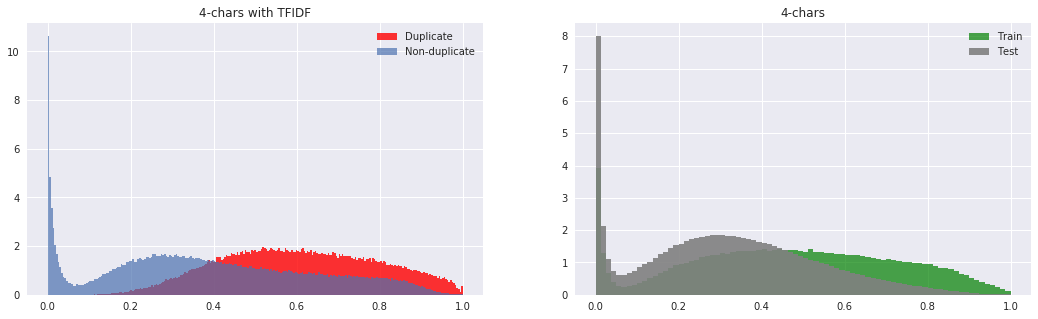

In [683]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("4-chars with TFIDF")
plt.hist(X_train['char_tfidf_cos'][mask], bins=250, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(X_train['char_tfidf_cos'][~mask], bins=250, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("4-chars")
plt.hist(X_train['char_tfidf_cos'], bins=80, color='g', alpha=0.7, normed=True, label='Train');
plt.hist(X_test['char_tfidf_cos'], bins=80, color='grey', alpha=0.9, normed=True, label='Test');
plt.legend()
plt.show()

**False Duplicates**

In [684]:
train_data[(X_train['char_tfidf_cos'] == 1) & ~mask][['question1', 'question2', 'is_duplicate']].head(10)

,question1,question2,is_duplicate
3148,How do I overcome my inferiority complex ?,How do I overcome my inferiority complex?,0
13597,How do spiders sleep?,Do spiders sleep?,0
23507,What is the purpose of life ?,What is the purpose of life?,0
35641,What to do ?,What to do?,0
66762,What should I do after completing BCA ?,What should I do after completing BCA?,0
107779,Do Indian women respect Indian men?,Do Indian men respect Indian women?,0
146239,Why do the Irish hate the English?,Why do the english hate the irish?,0
154185,What are the type of questions which belong to...,What are the type of questions which belong to...,0
164973,How should I prepare ?,How should I prepare?,0
199536,Why should I believe in god ?,Why should I believe in God?,0


### Identical questions!

Train

In [882]:
train_data[train_data['question1'].apply(lambda x: x[:-2]) == train_data['question2']][['question1','question2']]

,question1,question2
4489,What are the safety precautions on handling sh...,What are the safety precautions on handling sh...
29530,Which American restaurant chains can be found ...,Which American restaurant chains can be found ...
31627,How do I get into Stanford with a poor GPA? E,How do I get into Stanford with a poor GPA?
67511,Why did Apple change its name from Apple Compu...,Why did Apple change its name from Apple Compu...
70303,How much computer science does an 8 year old U...,How much computer science does an 8 year old U...
145928,How have you helped to create positive change ...,How have you helped to create positive change ...
151228,What are human beings instinctively afraid of?'?,What are human beings instinctively afraid of?
158615,What new paradigms do you think may be signifi...,What new paradigms do you think may be signifi...
190707,What is limit for chemical oxygen demand for d...,What is limit for chemical oxygen demand for d...
211885,Are there statistics available for birth-date ...,Are there statistics available for birth-date ...


In [883]:
train_data[train_data['question2'].apply(lambda x: x[:-2]) == train_data['question1']][['question1','question2']]

,question1,question2
70341,"If ads were removed from YouTube, how would yo...","If ads were removed from YouTube, how would yo..."
72656,What are the skills required for big data jobs?,What are the skills required for big data jobs?
332363,"What are the differences between small-cap, mi...","What are the differences between small-cap, mi..."
333542,What are you most passionate about and engaged...,What are you most passionate about and engaged...
360473,What did you enjoy most in your undergraduate ...,What did you enjoy most in your undergraduate ...
366359,How will you teach your grandmother to post ph...,How will you teach your grandmother to post ph...


Test

In [168]:
test_data[test_data['question2'] == test_data['question1']].head(10)

,test_id,question1,question2
10620,10620,What is the police code?,What is the police code?
37823,37823,How love?,How love?
43119,43119,What is?,What is?
106366,106366,What is the,What is the
129019,129019,Is good or bad?,Is good or bad?
239355,239355,I universe?,I universe?
276281,276281,What is?,What is?
321797,321797,What training?,What training?
330765,330765,What confidence?,What confidence?
391916,391916,What is the reproduction cycle of?,What is the reproduction cycle of?


### Saving features

In [791]:
X_train.to_csv('train_f1.csv', index=False)
X_test.to_csv('test_f1.csv', index=False)

In [ ]:
######### Loading ############
#
X_train = pd.read_csv('train_f1.csv')
X_test = pd.read_csv('test_f1.csv')

### Oversampling

In [806]:
x_train = X_train
y_train = pd.DataFrame(Y_train)

pos_train = x_train[y_train['is_duplicate'] == 1]
neg_train = x_train[y_train['is_duplicate'] == 0]

p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [807]:
x_train.columns

Index(['word_count_q1', 'word_count_q2', 'diff_word_count', 'nonstop_count_q1',
       'nonstop_count_q2', 'diff_nonstopword_count', 'char_count_q1',
       'char_count_q2', 'spec_char_q1', 'spec_char_q2', 'match_ratio',
       'jaccard', 'jaccard_stop', 'jaccard_split', 'jaccard_lem', 'overlap',
       'overlap_stop', 'overlap_split', 'overlap_lem', 'symmetric_diff',
       'fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio',
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'unigram_cos',
       'unigram_tfidf_cos', 'tfidf_mean1', 'tfidf_mean2', 'char_tfidf_cos',
       'tfidf_sum1', 'tfidf_sum2', 'tfidf_len1', 'tfidf_len2'],
      dtype='object')

## Training

In [808]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=2017)

params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.05
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 5
params["silent"] = 1
params["seed"] = 2107

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 500, watchlist, verbose_eval=50)

[0]	train-logloss:0.667727	valid-logloss:0.667779
[50]	train-logloss:0.357567	valid-logloss:0.3582
[100]	train-logloss:0.335173	valid-logloss:0.336444
[150]	train-logloss:0.328444	valid-logloss:0.330295
[200]	train-logloss:0.322899	valid-logloss:0.325387
[250]	train-logloss:0.319014	valid-logloss:0.321961
[300]	train-logloss:0.315674	valid-logloss:0.31909
[350]	train-logloss:0.313182	valid-logloss:0.316996
[400]	train-logloss:0.311084	valid-logloss:0.315397
[450]	train-logloss:0.30905	valid-logloss:0.313825


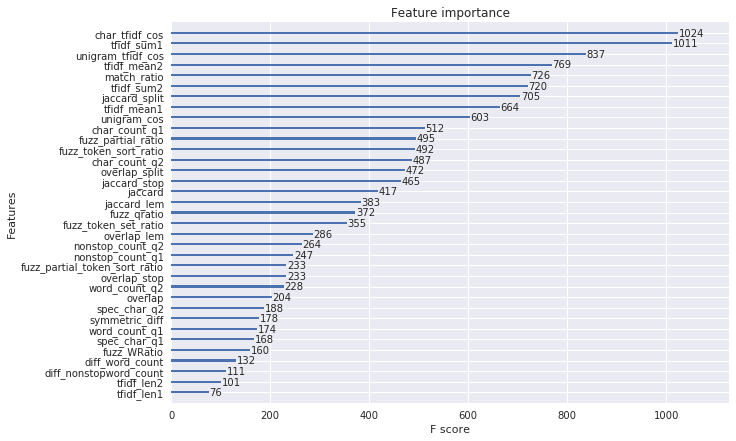

In [814]:
plt.rcParams['figure.figsize'] = (10, 7.0)
xgb.plot_importance(bst); plt.show()

### Question pairs on which the model is wrong

In [ ]:
def loss(y, pred):
    return  - (y * np.log(pred) + (1 - y) * np.log(1 - pred))

In [812]:
monitoring = pd.DataFrame(index=x_valid.index, data={'y': list(y_valid), 'pred': list(bst.predict(d_valid))})
monitoring = pd.concat((monitoring, train_data.loc[x_valid.index][['question1','question2']]), axis=1)

In [813]:
nondupicates = monitoring[monitoring.y == 0].sort('pred', ascending=False)
dupicates = monitoring[monitoring.y == 1].sort('pred')
monitoring['loss'] = monitoring.apply(lambda x: loss(x.y, x.pred), axis=1)
monitoring.sort('loss', ascending=False, inplace=True)

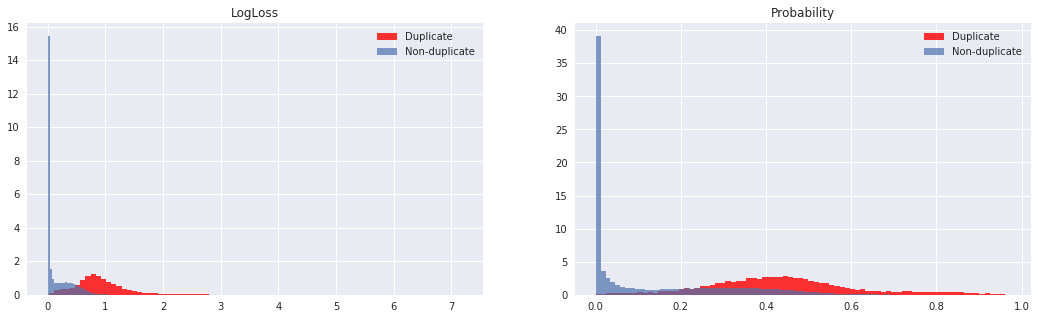

In [879]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("LogLoss")
plt.hist(monitoring[monitoring.y == 1]['loss'], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(monitoring[monitoring.y == 0]['loss'], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend()

plt.subplot(1,2,2)
plt.title("Probability")
plt.hist(monitoring[monitoring.y == 1]['pred'], bins=80, alpha=0.8, color='r', normed=True, label='Duplicate');
plt.hist(monitoring[monitoring.y == 0]['pred'], bins=80, alpha=0.7, normed=True, label='Non-duplicate');
plt.legend();

In [886]:
for i in range(len(monitoring)):
    print("Prediction: %.4f" % monitoring['pred'].iloc[i])
    print("LogLoss: %.4f" % monitoring['loss'].iloc[i])
    print(dupicates['question1'].iloc[i])
    print(dupicates['question2'].iloc[i], "\n")
    if i == 20:
        break

Prediction: 0.0007
LogLoss: 7.1957
I got the Pokemon Y rom but I cannot find the emulator. Where can I find it?
How can I play Pokemon X and Y on a PC? 

Prediction: 0.0008
LogLoss: 7.1844
What ethnicity were the Moors of Sicily?
Who were the moors? 

Prediction: 0.0008
LogLoss: 7.1019
What if Bernie Sanders had won the Democratic nomination, would he have been chosen as president?
Could Sanders have won had Hillary not stole the election from him? 

Prediction: 0.0008
LogLoss: 7.0787
If Hannibal was a great general, how come he didn't attack Rome when he had the chance?
Why didn't Hannibal besiege Rome after he destroyed the armies Rome had sent to defeat him? Couldn't he lay siege to Rome and eventually make it surrender by starving its people? 

Prediction: 0.0023
LogLoss: 6.0900
What are advantages of BITS over IIT and vice versa?
Why would someone choose BITS Pilani over IIT? 

Prediction: 0.0028
LogLoss: 5.8865
What existed before space and time?
What was there before the "beginn

**False negative**

In [885]:
for i in range(len(monitoring)):
    print(dupicates['pred'].iloc[i])
    print(dupicates['question1'].iloc[i])
    print(dupicates['question2'].iloc[i], "\n")
    if i == 20:
        break

0.000749797560275
I got the Pokemon Y rom but I cannot find the emulator. Where can I find it?
How can I play Pokemon X and Y on a PC? 

0.000758338253945
What ethnicity were the Moors of Sicily?
Who were the moors? 

0.000823501788545
What if Bernie Sanders had won the Democratic nomination, would he have been chosen as president?
Could Sanders have won had Hillary not stole the election from him? 

0.000842880399432
If Hannibal was a great general, how come he didn't attack Rome when he had the chance?
Why didn't Hannibal besiege Rome after he destroyed the armies Rome had sent to defeat him? Couldn't he lay siege to Rome and eventually make it surrender by starving its people? 

0.00226548477076
What are advantages of BITS over IIT and vice versa?
Why would someone choose BITS Pilani over IIT? 

0.00277670589276
What existed before space and time?
What was there before the "beginning"? 

0.00370135204867
Can I travel outside USA while my OPT Extension application is still pending?
I

**False positive**

In [887]:
for i in range(len(monitoring)):
    print(nondupicates['pred'].iloc[i])
    print(nondupicates['question1'].iloc[i])
    print(nondupicates['question2'].iloc[i], "\n")
    if i == 20:
        break

0.933835506439
What is the output of this program? ?
What is the output of this program? 

0.895287811756
As a theist, what do you wish atheists knew?
As an atheist, what do you wish theists knew? 

0.894331037998
How do you solve the following recursion using recursion tree?
How do I solve the following recursion using recursion tree? 

0.891326129436
What is difference between braced and unbraced frames?
What is the difference between braced and unbraced frames? 

0.880692362785
What my palm line says?
What my palm lines say? 

0.880252957344
What is the activation energy?
What is activation energy? 

0.879678845406
Why in katy Perry -part of me song the watch get highlighted? See the image
Why in katy Perry -part of me song the watch get highlighted? See the image? 

0.877382278442
Jimmy Kimmel or Jimmy Fallon?
Who is a better host according to you, Jimmy Kimmel or Jimmy Fallon? 

0.87647652626
What are the characteristics of limestone?
What is the characteristic of limestone? 

0.8

## Prediction

In [800]:
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = sample['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)